# Classifying Names with a Character-Level RNN

From http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Libraries

In [1]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from io import open
import random
import glob
import unicodedata
import string
import time
import math

torch.manual_seed(1)

## Data preparation

In [2]:
DATA_PATH = '../data'

In [3]:
def findFiles(path): return glob.glob(path)

print(findFiles('{}/names/*.txt'.format(DATA_PATH)))

['../data/names\\Arabic.txt', '../data/names\\Chinese.txt', '../data/names\\Czech.txt', '../data/names\\Dutch.txt', '../data/names\\English.txt', '../data/names\\French.txt', '../data/names\\German.txt', '../data/names\\Greek.txt', '../data/names\\Irish.txt', '../data/names\\Italian.txt', '../data/names\\Japanese.txt', '../data/names\\Korean.txt', '../data/names\\Polish.txt', '../data/names\\Portuguese.txt', '../data/names\\Russian.txt', '../data/names\\Scottish.txt', '../data/names\\Spanish.txt', '../data/names\\Vietnamese.txt']


In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Read all files
for filename in findFiles('{}/names/*.txt'.format(DATA_PATH)):
    category = filename.split('/')[-1].split('.')[0].split('\\')[-1]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [7]:
category_lines['Vietnamese'][1:10]

['Tron', 'Le', 'Pham', 'Huynh', 'Hoang', 'Phan', 'Vu', 'Vo', 'Dang']

#### From names to tensors of letters

To represent a single letter, we use a "one-hot vector" of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [8]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

letterToIndex('y')

24

In [9]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [10]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

lineToTensor('Jones')

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,

## Model

This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [12]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [13]:
rnn(lineToTensor('Albert')[0], torch.zeros(1, n_hidden))

(tensor([[-2.8739, -2.9028, -2.8908, -2.8810, -2.9101, -2.8985, -2.9106,
          -2.9278, -2.9383, -2.8299, -2.8164, -2.7802, -3.0030, -2.8686,
          -2.8727, -2.9259, -2.9581, -2.8613]]),
 tensor([[ 0.0366,  0.0225,  0.0708, -0.0385,  0.0178, -0.0594,  0.1098,
           0.0313, -0.0124, -0.0531,  0.1124, -0.0163,  0.0029, -0.0306,
          -0.0145, -0.0395, -0.0657,  0.0420,  0.0152,  0.0811,  0.0221,
           0.1079,  0.0078,  0.0289,  0.0194,  0.0564, -0.0383, -0.0354,
          -0.0176,  0.0266,  0.0718, -0.0345, -0.1332,  0.0068,  0.0023,
          -0.0116, -0.0452, -0.0823,  0.1196,  0.0225,  0.1072,  0.0365,
          -0.0628,  0.0230,  0.0613,  0.0823,  0.0255,  0.0628,  0.0675,
           0.0179,  0.0185,  0.0136,  0.0169,  0.0167,  0.0931,  0.0104,
           0.0371, -0.0294,  0.0551,  0.0226, -0.0818,  0.1440,  0.0680,
           0.0151,  0.0009, -0.0173, -0.0005,  0.1138,  0.0037, -0.1238,
          -0.0228,  0.1202, -0.0505, -0.0571,  0.0612, -0.0445, -0.0035,
  

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [14]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [15]:
print(categoryFromOutput(rnn(lineToTensor('Albert')[0], torch.zeros(1, n_hidden))[0]))

('Korean', 11)


We will also want a quick way to get a training example (a name and its language):

In [16]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Almeida
category = Vietnamese / line = Chau
category = German / line = Tifft
category = German / line = Lewerenz
category = Korean / line = Hyun 
category = English / line = Faulkner
category = Polish / line = Grzeskiewicz
category = English / line = Harrison
category = Greek / line = Phocas
category = Czech / line = Cvacek


## Training

In [17]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [18]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.9323 Martin / Irish ✗ (Scottish)
10000 10% (0m 10s) 2.4725 Prachar / Arabic ✗ (Czech)
15000 15% (0m 15s) 2.8900 Archambault / Polish ✗ (French)
20000 20% (0m 20s) 3.5747 Jamussa / Czech ✗ (Greek)
25000 25% (0m 25s) 0.2743 Hayuata / Japanese ✓
30000 30% (0m 30s) 1.9492 Ludgrove / French ✗ (English)
35000 35% (0m 35s) 0.7939 Donnchadh / Irish ✓
40000 40% (0m 41s) 0.7711 Chu / Vietnamese ✓
45000 45% (0m 46s) 2.2167 Macarthur / Scottish ✗ (English)
50000 50% (0m 51s) 0.5951 Jaskulski / Polish ✓
55000 55% (0m 56s) 2.0354 Faust / French ✗ (German)
60000 60% (1m 0s) 0.4612 Milionis / Greek ✓
65000 65% (1m 5s) 0.0690 Tumicelli / Italian ✓
70000 70% (1m 10s) 1.5391 Chung / Korean ✗ (Vietnamese)
75000 75% (1m 15s) 2.5818 Mendel / Irish ✗ (German)
80000 80% (1m 20s) 2.1999 Kidman / Polish ✗ (English)
85000 85% (1m 25s) 0.2009 Ramires / Portuguese ✓
90000 90% (1m 29s) 0.5648 Lao / Chinese ✓
95000 95% (1m 35s) 0.1695 Coilean / Irish ✓
100000 100% (1m 40s) 0.2248 Qin / Chinese ✓


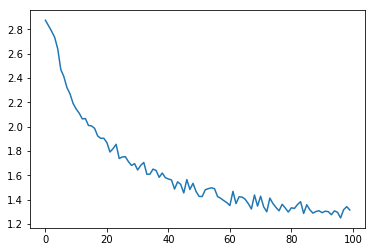

In [19]:
plt.figure()
plt.plot(all_losses)

In [20]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [21]:
categoryFromOutput(evaluate(lineToTensor('Fanilo')))

('Portuguese', 13)

# Generating Names with a Character-Level RNN

Using http://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

We are still hand-crafting a small RNN with a few linear layers. The big difference is instead of predicting a category after reading in all the letters of a name, we input a category and output one letter at a time. Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a “language model”.

This network extends the last tutorial’s RNN with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer `o2o` (after combining hidden and output) to give it more muscle to work with. There’s also a dropout layer, which randomly zeros parts of its input with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we’re using it towards the end of the network to purposely add some chaos and increase sampling variety.

In [22]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [23]:
# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [25]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [26]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [28]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [29]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 12s (5000 5%) 2.6813
0m 24s (10000 10%) 3.4537
0m 36s (15000 15%) 2.5142
0m 47s (20000 20%) 3.2292
0m 59s (25000 25%) 2.7655
1m 11s (30000 30%) 1.9718
1m 23s (35000 35%) 2.2111
1m 34s (40000 40%) 3.8189
1m 47s (45000 45%) 2.0394
1m 59s (50000 50%) 2.2663
2m 10s (55000 55%) 2.2220
2m 21s (60000 60%) 2.3521
2m 33s (65000 65%) 2.8746
2m 45s (70000 70%) 2.0979
2m 56s (75000 75%) 2.8064
3m 7s (80000 80%) 1.6810
3m 19s (85000 85%) 2.5555
3m 31s (90000 90%) 2.6908
3m 43s (95000 95%) 2.9135
3m 54s (100000 100%) 2.8364


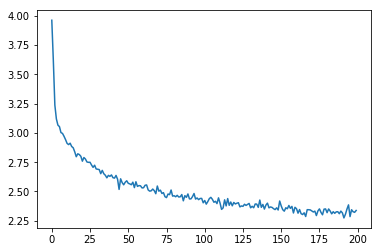

In [30]:
plt.figure()
plt.plot(all_losses)

In [32]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

    
sample('Russian', 'F')

'Farton'